<a href="https://colab.research.google.com/github/AbrahamKong/CMPE257-Decision_Tree/blob/main/CMPE257_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Statement

Author: Abraham Kong

Team: Data Miners

Objective: 
Using Classfication methods to find out if product Category is one parameter effecting the churn rate of customers

### Data Set

[Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce)


### Preparing the Data

In [1]:
#Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import plotly.express as px
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the Necessary Datasets

customers = pd.read_csv('/content/olist_customers_dataset.csv')
order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
order_payments= pd.read_csv('/content/olist_order_payments_dataset.csv')
orders = pd.read_csv('/content/olist_orders_dataset.csv')
sellers= pd.read_csv('/content/olist_sellers_dataset.csv')
products = pd.read_csv('/content/olist_products_dataset.csv')

In [3]:
# Merge all the Data into one dataframe

df1 = order_payments.merge(order_items, on="order_id")
df2 = df1.merge(orders, on="order_id")
df3 = df2.merge(customers, on="customer_id")
df = df3.merge(products, on='product_id')
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,teofilo otoni,MG,casa_construcao,57.0,921.0,8.0,800.0,17.0,27.0,17.0
1,d86305c284cecff56c7ee9d3fbd4f8d6,1,credit_card,4,93.72,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-04-19 23:10:02,79.80,...,barretos,SP,casa_construcao,57.0,921.0,8.0,800.0,17.0,27.0,17.0
2,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,sao paulo,SP,automotivo,59.0,1274.0,2.0,150.0,16.0,6.0,11.0
3,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,sao paulo,SP,perfumaria,54.0,1536.0,2.0,250.0,20.0,8.0,21.0
4,1966886b80f14d0588adf6406afb0026,1,debit_card,1,68.89,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-09-01 16:06:59,56.99,...,pouso alegre,MG,perfumaria,54.0,1536.0,2.0,250.0,20.0,8.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117596,6a87a0371f263aa8c1779c2c115c1427,1,credit_card,2,83.09,1,1f58e3c365e615b33b2b30b068d7578a,2a5b78b41cd05baeac8df54c6606b92c,2017-11-30 16:13:44,74.82,...,formiga,MG,beleza_saude,58.0,813.0,1.0,600.0,20.0,10.0,15.0
117597,e0657085c2b6297a32f39efa200cdf72,1,credit_card,1,26.37,1,e2336d327209ca849dca5afda036f842,a8739afb32aaa45e01815ca76f76f54b,2018-08-07 21:24:28,18.98,...,sao paulo,SP,eletronicos,38.0,459.0,1.0,250.0,18.0,19.0,18.0
117598,9ac048d7ffebba67d54456aa9ec07d7e,1,credit_card,1,60.69,1,0dcb1adbafdcc389972874b01fa249b8,2f74af7a0ee5636f12c2336f9fffed47,2017-11-24 19:09:29,44.90,...,salvador,BA,esporte_lazer,39.0,411.0,3.0,350.0,23.0,23.0,23.0
117599,c45067032fd84f4cf408730ff5205568,1,credit_card,2,198.94,1,fea2f92877b647dc07ea8e3f4aa2cf3f,406822777a0b9eb5c50e442dd4cd3ec5,2018-05-22 12:30:57,179.80,...,foz do iguacu,PR,brinquedos,35.0,537.0,2.0,7400.0,45.0,29.0,53.0


In [4]:
# These are the final data to start with
df.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [5]:
# Drop unnecessary columns

df = df.drop(columns=['order_approved_at', 'customer_unique_id', 'order_delivered_carrier_date', 'shipping_limit_date', 'customer_city', 'customer_state', 'freight_value', 'order_delivered_customer_date', 'customer_zip_code_prefix', 'seller_id', 'payment_sequential'])

In [6]:
# These are the final data to start with
df.columns

Index(['order_id', 'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'price', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_estimated_delivery_date',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

### Label Encode the Data for Decision Tree Classification

In [11]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'. 
df['product_category_name']= label_encoder.fit_transform(df['product_category_name']) 
df['customer_id']= label_encoder.fit_transform(df['product_category_name']) 
df.head()

,order_id,payment_type,payment_installments,payment_value,order_item_id,product_id,price,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,79.80,16,delivered,2018-04-25 22:01:49,2018-05-22 00:00:00,16,57.0,921.0,8.0,800.0,17.0,27.0,17.0
1,d86305c284cecff56c7ee9d3fbd4f8d6,credit_card,4,93.72,1,af74cc53dcffc8384b29e7abfa41902b,79.80,16,delivered,2018-04-15 22:53:59,2018-05-09 00:00:00,16,57.0,921.0,8.0,800.0,17.0,27.0,17.0
2,a9810da82917af2d9aefd1278f1dcfa0,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,17.00,8,delivered,2018-06-26 11:01:38,2018-07-16 00:00:00,8,59.0,1274.0,2.0,150.0,16.0,6.0,11.0
3,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,56.99,62,delivered,2017-12-12 11:19:55,2018-01-04 00:00:00,62,54.0,1536.0,2.0,250.0,20.0,8.0,21.0
4,1966886b80f14d0588adf6406afb0026,debit_card,1,68.89,1,2028bf1b01cafb2d2b1901fca4083222,56.99,62,invoiced,2017-08-22 16:01:44,2017-09-19 00:00:00,62,54.0,1536.0,2.0,250.0,20.0,8.0,21.0


### Decision Tree Classification

In [12]:
from sklearn.model_selection import train_test_split

X = df[['customer_id', 'price']]
y = df['product_category_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
df['customer_id']

0         16
1         16
2          8
3         62
4         62
          ..
117596    11
117597    30
117598    32
117599    12
117600     8
Name: customer_id, Length: 117601, dtype: int64

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)
print(y_pred[0:5])

[66 40 50 32 62]


### Visualize Decision Tree

In [29]:
from sklearn import tree

text_representation = tree.export_text(dt)
print(text_representation)

|--- feature_0 <= 13.50
|   |--- feature_0 <= 12.50
|   |   |--- feature_0 <= 10.50
|   |   |   |--- feature_0 <= 8.50
|   |   |   |   |--- feature_0 <= 7.50
|   |   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_0 >  1.50
|   |   |   |   |   |   |--- class: 7
|   |   |   |   |--- feature_0 >  7.50
|   |   |   |   |   |--- class: 8
|   |   |   |--- feature_0 >  8.50
|   |   |   |   |--- feature_0 <= 9.50
|   |   |   |   |   |--- class: 9
|   |   |   |   |--- feature_0 >  9.50
|   |   |   |   |   |--- class: 10
|   |   |--- feature_0 >  10.50
|   |   |   |--- feature_0 <= 11.50
|   |   |   |   |--- class: 11
|   |   |   |--- feature_0 >  11.50
|   |   |   |   |--- class: 12
|   |--- feature_0 >  12.50
|   |   |--- class: 13
|--- feature_0 >  13.50
|   |--- feature_0 <= 71.50
|   |   |--- feature_0 <= 65.50
|   |   |   |--- feature_0 <= 53.50
|   |   |   |   |--- feature_0 <= 43.50
|   |   |   |   |   |--- feature_0 <= 39.50
|   

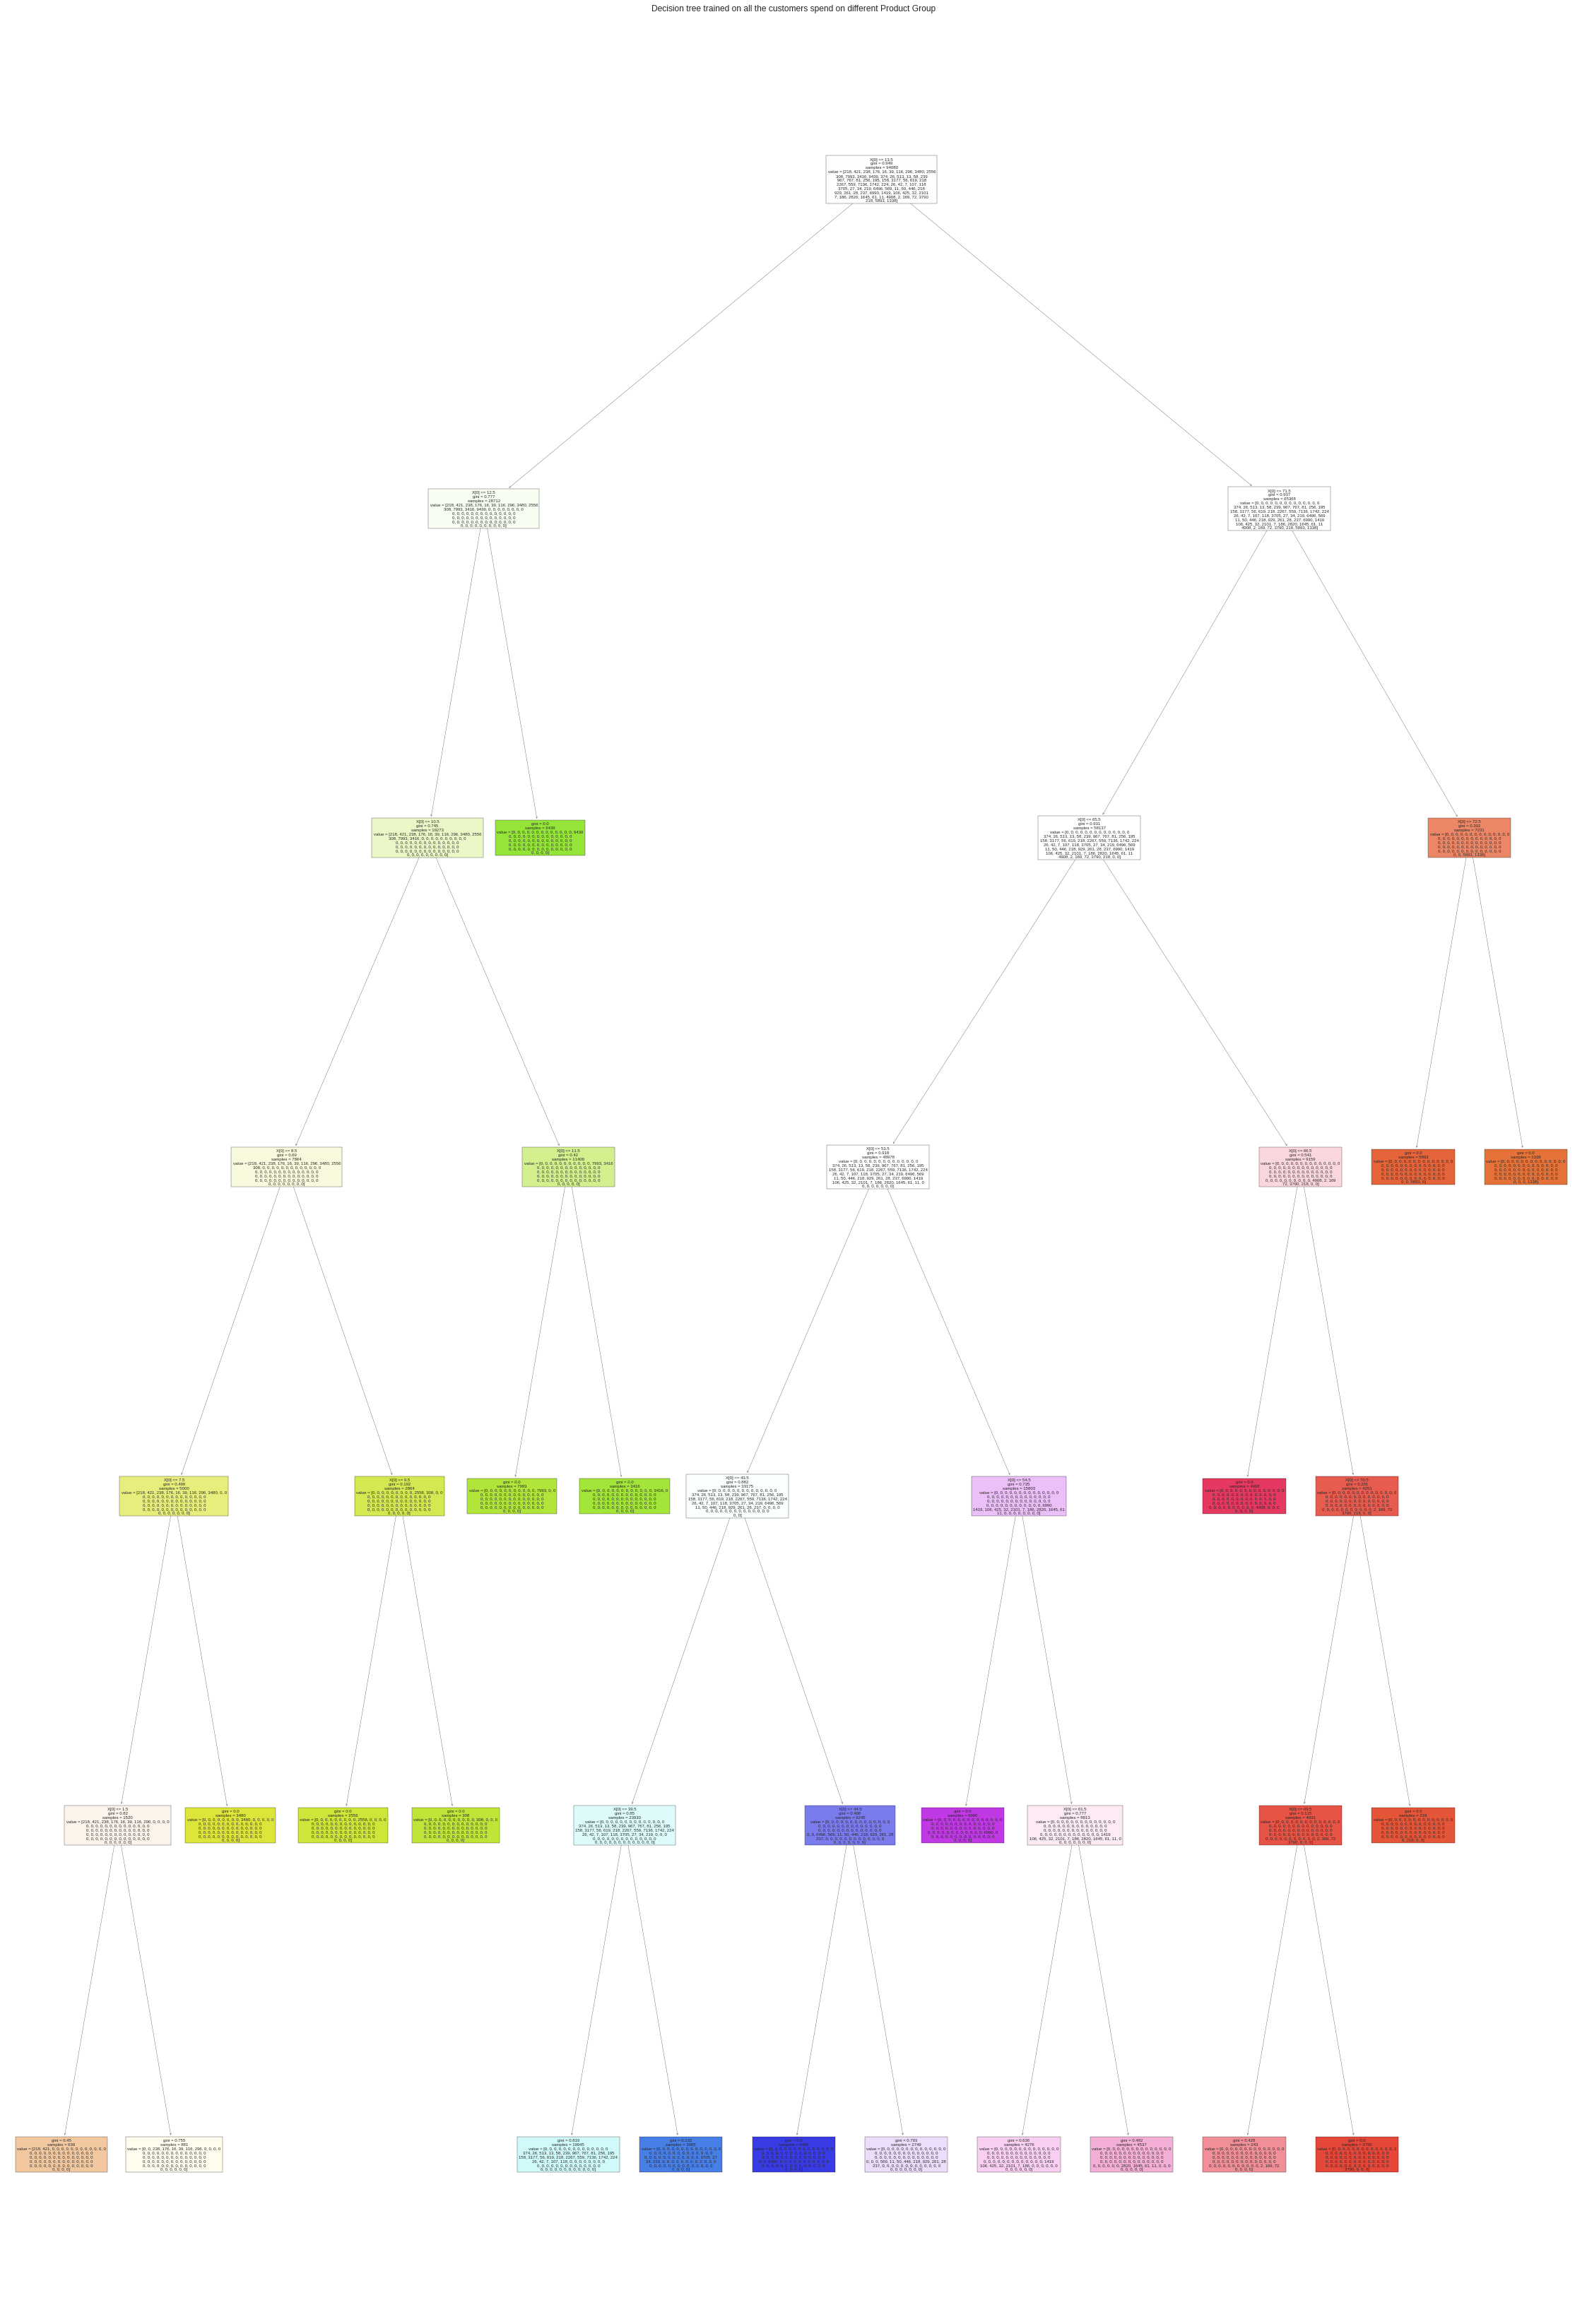

In [27]:
from sklearn.tree import plot_tree

plot_tree(dt, filled=True)
plt.title("Decision tree trained on all the customers spend on different Product Group")
plt.rcParams["figure.figsize"] = (80,40)
plt.show()

## Observation


Based on the classifier, 

we can tell which group of product category is more interesting to customers

and we can suggest the business owner to give more incentives to the seller

to ask to provide mroe products of these categories